## Plot microsatellite instability classification results

Here, we'll visualize the results of the MSI prediction experiments. Remember that we're trying to classify MSI-H ("high" microsatellite instability, inferred from sequencing assays) against all other classes (MSI-L = "low" microsatellite instability, MSS = "microsatellite stable" tumors, "indeterminate" tumors).

Results analyzed here are generated by the `run_msi_prediction.py` script.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.data_utilities as du

### Load results

In [3]:
# set results directory
results_dir = Path(cfg.results_dirs['msi'], 'msi_5000_top_mad').resolve()

In [4]:
results_df = au.load_msi_results(results_dir)

print(results_df.shape)
print(results_df.training_data.unique())
results_df.head()

(1152, 8)
['mut_sigs' 'rppa' 'me_450k' 'mirna' 'expression' 'me_27k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold
0,0.96743,0.90884,UCEC,mut_sigs,signal,1,train,0
1,0.93833,0.90127,UCEC,mut_sigs,signal,1,test,0
2,0.82158,0.72292,UCEC,mut_sigs,signal,1,cv,0
3,0.97770,0.92083,UCEC,mut_sigs,signal,1,train,1
4,0.92513,0.89177,UCEC,mut_sigs,signal,1,test,1


### Plot results per cancer type, on true labels

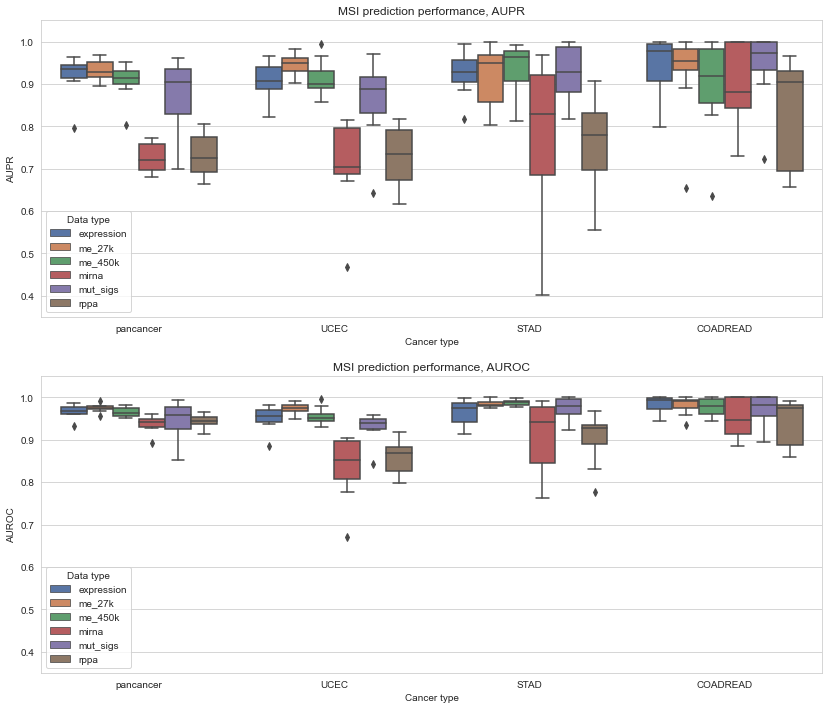

In [6]:
sns.set({'figure.figsize': (14, 12)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(2, 1)

plot_df = (
    results_df[(results_df.data_type == 'test') &
               (results_df.signal == 'signal')]
      .sort_values(by=['signal', 'training_data'])
)

sns.boxplot(data=plot_df, x='identifier', y='aupr', hue='training_data', ax=axarr[0])
axarr[0].set_title('MSI prediction performance, AUPR')
axarr[0].set_xlabel('Cancer type')
axarr[0].set_ylabel('AUPR')
axarr[0].set_ylim(0.35, 1.05)
axarr[0].legend(title='Data type')

sns.boxplot(data=plot_df, x='identifier', y='auroc', hue='training_data', ax=axarr[1])
axarr[1].set_title('MSI prediction performance, AUROC')
axarr[1].set_xlabel('Cancer type')
axarr[1].set_ylabel('AUROC')
axarr[1].set_ylim(0.35, 1.05)
axarr[1].legend(title='Data type')

### Plot results per cancer type, corrected for permuted labels baseline

TODO: also look at mutational signatures used for prediction

In [10]:
compare_df = au.compare_all_data_types(results_df,
                                       sig_alpha=0.05,
                                       filter_genes=False,
                                       compare_ind=True,
                                       metric='auroc')
compare_df.rename(columns={'gene': 'cancer_type'}, inplace=True)

compare_aupr_df = au.compare_all_data_types(results_df,
                                            sig_alpha=0.05,
                                            filter_genes=False,
                                            compare_ind=True,
                                            metric='aupr')
compare_aupr_df.rename(columns={'gene': 'cancer_type'}, inplace=True)

print(compare_df.shape)
print(compare_df.training_data.unique())
compare_df.head()

(192, 5)
['mut_sigs' 'rppa' 'me_450k' 'mirna' 'expression' 'me_27k']


,cancer_type,seed,fold,delta_auroc,training_data
0,COADREAD,1,0,0.50595,mut_sigs
1,COADREAD,1,1,0.43859,mut_sigs
2,COADREAD,1,2,0.47557,mut_sigs
3,COADREAD,1,3,0.39908,mut_sigs
4,COADREAD,42,0,0.36061,mut_sigs


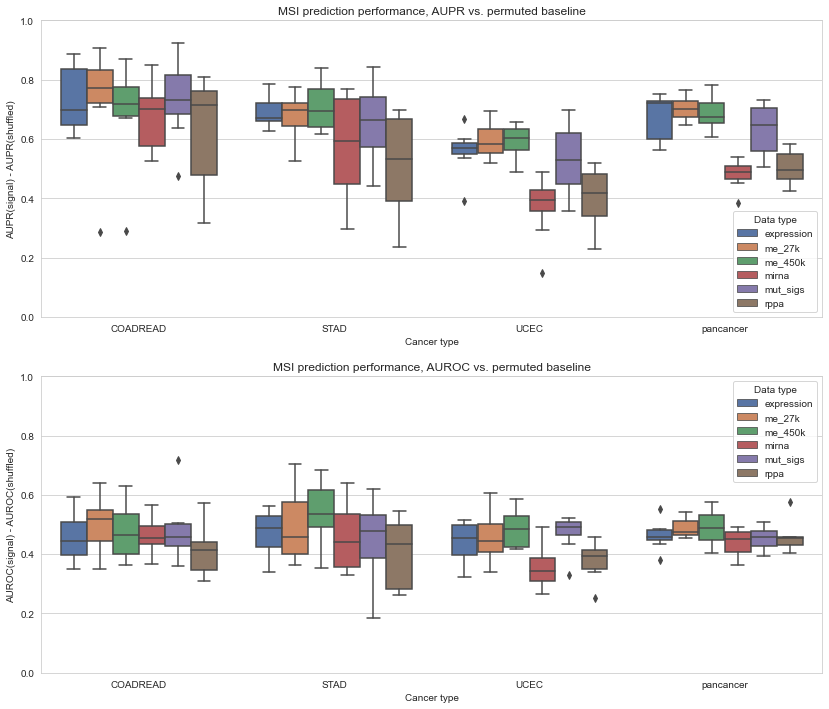

In [17]:
sns.set({'figure.figsize': (14, 12)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(2, 1)

sns.boxplot(data=compare_aupr_df, x='cancer_type', y='delta_aupr',
            hue='training_data',
            hue_order=sorted(compare_aupr_df.training_data.unique()),
            ax=axarr[0])
axarr[0].set_title('MSI prediction performance, AUPR vs. permuted baseline')
axarr[0].set_xlabel('Cancer type')
axarr[0].set_ylabel('AUPR(signal) - AUPR(shuffled)')
axarr[0].set_ylim(0.0, 1.0)
axarr[0].legend(title='Data type')

sns.boxplot(data=compare_df, x='cancer_type', y='delta_auroc',
            hue='training_data',
            hue_order=sorted(compare_df.training_data.unique()),
            ax=axarr[1])
axarr[1].set_title('MSI prediction performance, AUROC vs. permuted baseline')
axarr[1].set_xlabel('Cancer type')
axarr[1].set_ylabel('AUROC(signal) - AUROC(shuffled)')
axarr[1].set_ylim(0.0, 1.0)
axarr[1].legend(title='Data type')